## task:
### customers analysis and stratification
### use: KMeans

In [1]:
import pandas as pd

df = pd.read_csv("14.4 marketing campaign.csv")
df

,ID,Year_Birth,Dt_Customer,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,Response
0,5524,1957,04-09-2012,58,88,546,172,88,8,4,1
1,2174,1954,08-03-2014,38,1,6,2,1,1,2,0
2,4141,1965,21-08-2013,26,49,127,111,21,8,10,0
3,6182,1984,10-02-2014,26,4,20,10,3,2,4,0
4,5324,1981,19-01-2014,94,43,118,46,27,5,6,0
...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,13-06-2013,46,43,182,42,118,9,4,0
2236,4001,1946,10-06-2014,56,0,30,0,0,8,5,0
2237,7270,1981,25-01-2014,91,48,217,32,12,2,13,0
2238,8235,1956,24-01-2014,8,30,214,80,30,6,10,0


## data analysis

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 2240 non-null   int64 
 1   Year_Birth         2240 non-null   int64 
 2   Dt_Customer        2240 non-null   object
 3   Recency            2240 non-null   int64 
 4   MntFruits          2240 non-null   int64 
 5   MntMeatProducts    2240 non-null   int64 
 6   MntFishProducts    2240 non-null   int64 
 7   MntSweetProducts   2240 non-null   int64 
 8   NumWebPurchases    2240 non-null   int64 
 9   NumStorePurchases  2240 non-null   int64 
 10  Response           2240 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 192.6+ KB


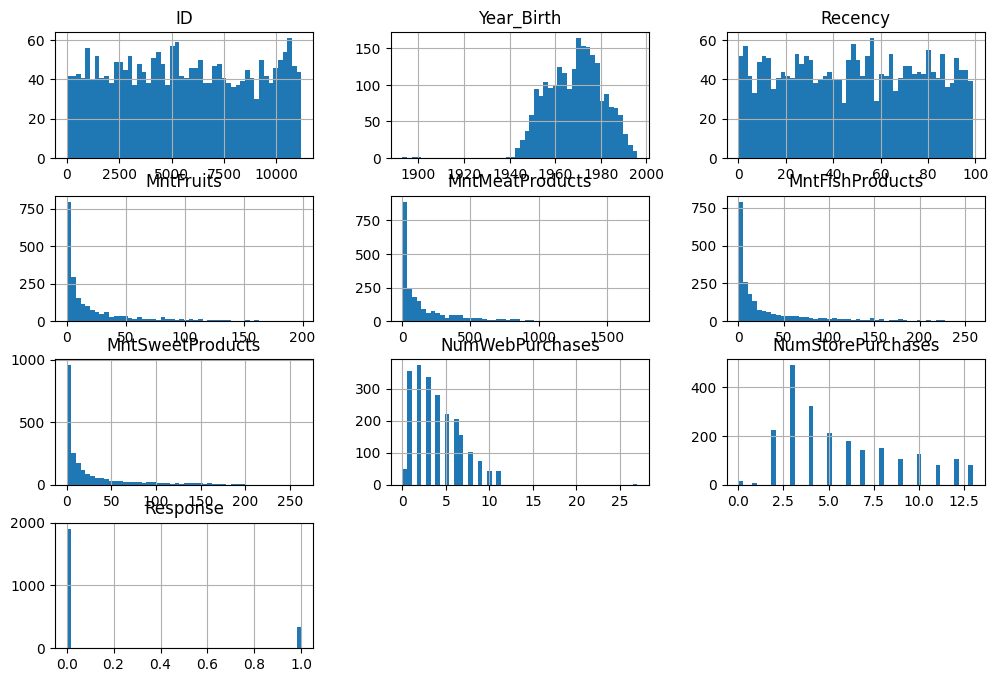

In [3]:
df.hist(bins=50, figsize=(12, 8));

<Axes: >

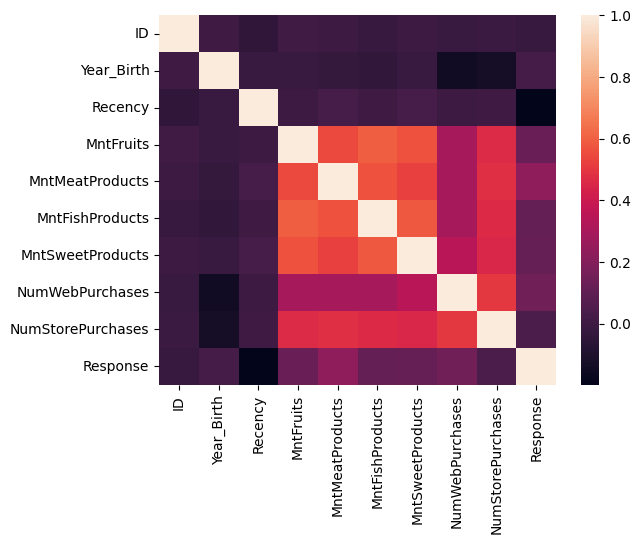

In [4]:
import seaborn as sns

sns.heatmap(df[df.describe().columns].corr(), annot=False)

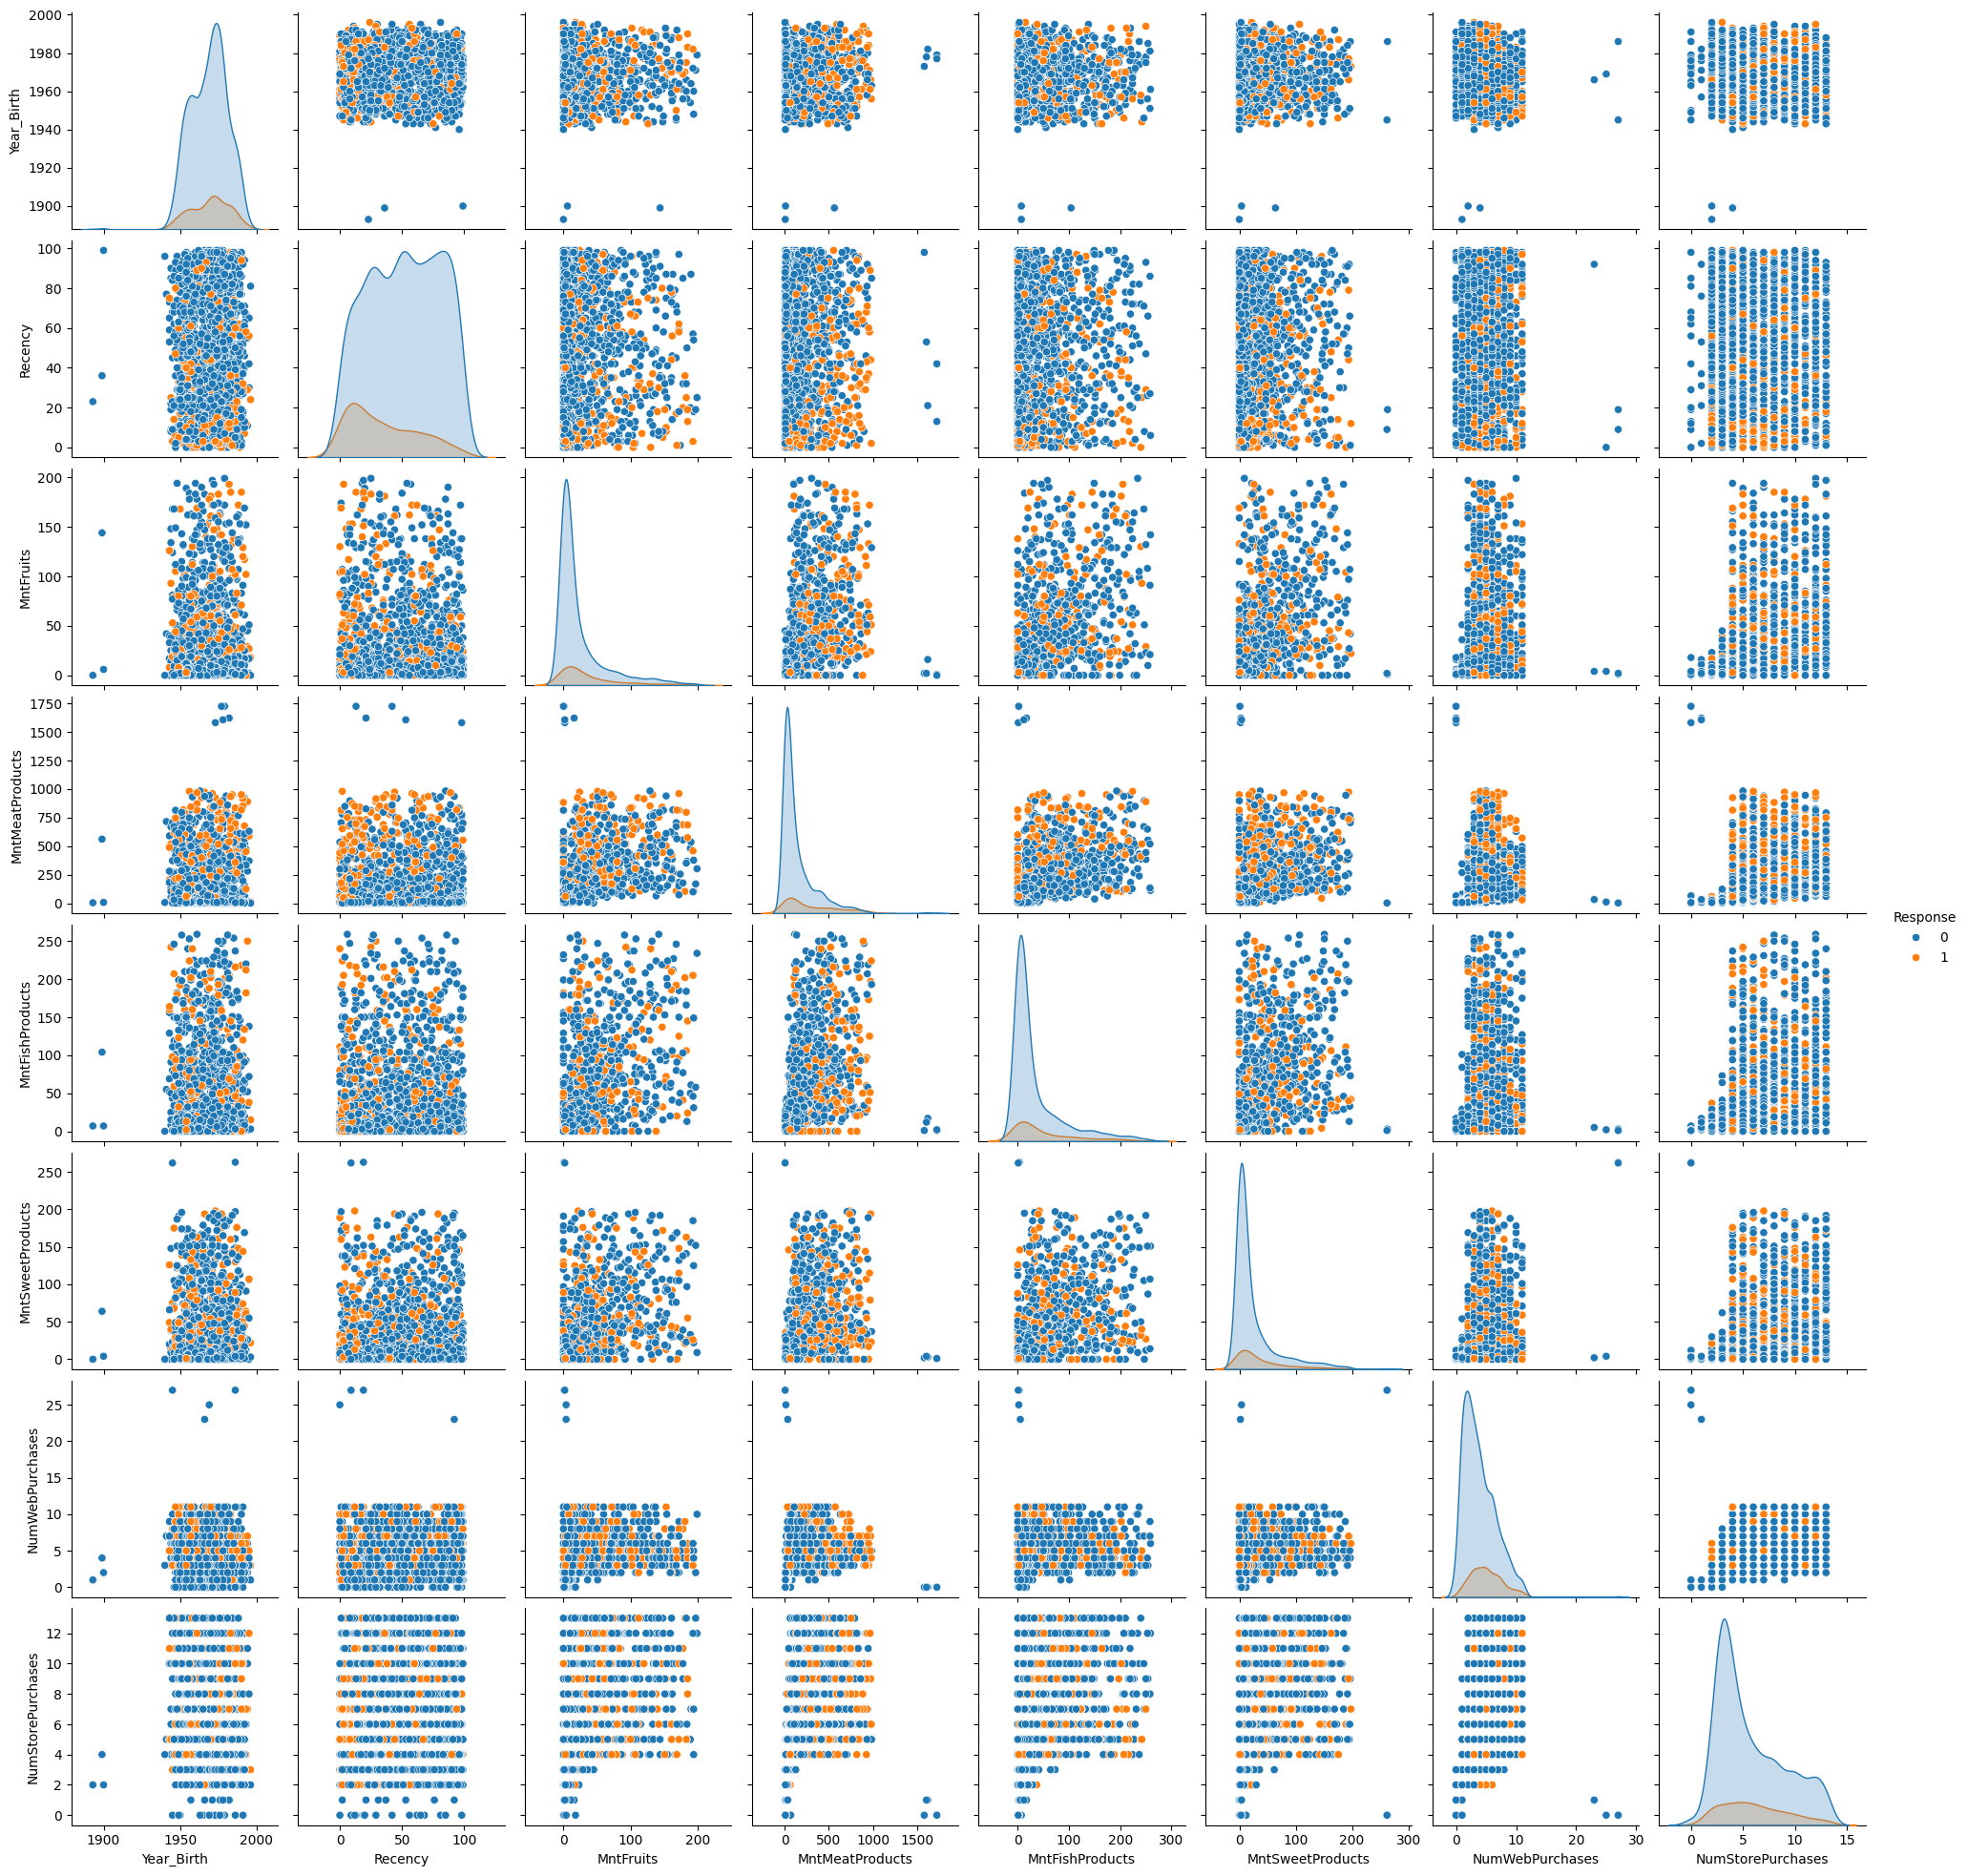

In [5]:
sns.pairplot(df, vars=['Year_Birth', 'Recency', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'NumWebPurchases',
       'NumStorePurchases'], hue='Response');

## pipeline preprocessing

In [8]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def to_days(X):
    X = pd.to_datetime(X.stack(), format='%d-%m-%Y')
    return (X - X.min()).dt.days.unstack()

def calculate_outliers(X):
    q25 = X.quantile(0.25)
    q75 = X.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    X[(X > boundaries[1]) | (X < boundaries[0])] = None    
    return X

days = make_pipeline(
    FunctionTransformer(to_days, feature_names_out="one-to-one"),
)

outliers = make_pipeline(
    FunctionTransformer(calculate_outliers, feature_names_out="one-to-one"),
    KNNImputer(),
)

ohe = make_pipeline(
    KNNImputer(),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
)

col_out = ['Year_Birth', 'Recency', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'NumWebPurchases', 'NumStorePurchases']

preprocessing = ColumnTransformer([
    ('date', days, ['Dt_Customer']),
    ('outliers', outliers, col_out),
    ('ohe', ohe, ['Response']),
    
], remainder='drop')

### prepared dataframe

In [9]:
tmp_out = preprocessing.fit_transform(df)
df_out = pd.DataFrame(tmp_out, columns=preprocessing.get_feature_names_out())
df_out

,date__Dt_Customer,outliers__Year_Birth,outliers__Recency,outliers__MntFruits,outliers__MntMeatProducts,outliers__MntFishProducts,outliers__MntSweetProducts,outliers__NumWebPurchases,outliers__NumStorePurchases,ohe__Response_0.0,ohe__Response_1.0
0,36.0,1957.0,58.0,31.8,546.0,66.8,44.2,8.0,4.0,0.0,1.0
1,586.0,1954.0,38.0,1.0,6.0,2.0,1.0,1.0,2.0,1.0,0.0
2,387.0,1965.0,26.0,49.0,127.0,111.0,21.0,8.0,10.0,1.0,0.0
3,560.0,1984.0,26.0,4.0,20.0,10.0,3.0,2.0,4.0,1.0,0.0
4,538.0,1981.0,94.0,43.0,118.0,46.0,27.0,5.0,6.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2235,318.0,1967.0,46.0,43.0,182.0,42.0,45.0,9.0,4.0,1.0,0.0
2236,680.0,1946.0,56.0,0.0,30.0,0.0,0.0,8.0,5.0,1.0,0.0
2237,544.0,1981.0,91.0,48.0,217.0,32.0,12.0,2.0,13.0,1.0,0.0
2238,543.0,1956.0,8.0,30.0,214.0,80.0,30.0,6.0,10.0,1.0,0.0


## KMeans analysis

In [28]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', KMeans(random_state=1, n_init=10)),
])

def scorer(estimator, X):
    km = estimator.fit(X)
    x2 = preprocessing.fit_transform(X)
    return { 'ss': silhouette_score(x2, km[1].labels_), 'el': km[1].inertia_ }

param = {
    'classifier__n_clusters': range(2,10),
}

cv = [(slice(None), slice(None))]
grid_search = GridSearchCV(estimator=full_pipeline, param_grid=param, cv=cv, n_jobs=-1, scoring=scorer, refit=False)
model = grid_search.fit(df)


In [11]:
res = pd.DataFrame(model.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_clusters,params,split0_test_ss,mean_test_ss,std_test_ss,rank_test_ss,split0_test_el,mean_test_el,std_test_el,rank_test_el
0,0.142044,0.0,0.318193,0.0,2,{'classifier__n_clusters': 2},0.423381,0.423381,0.0,2,7.418493e+07,7.418493e+07,0.0,1
1,0.183031,0.0,0.299445,0.0,3,{'classifier__n_clusters': 3},0.436955,0.436955,0.0,1,5.105631e+07,5.105631e+07,0.0,2
2,0.202960,0.0,0.268806,0.0,4,{'classifier__n_clusters': 4},0.415688,0.415688,0.0,3,3.755111e+07,3.755111e+07,0.0,3
3,0.200923,0.0,0.307907,0.0,5,{'classifier__n_clusters': 5},0.406019,0.406019,0.0,4,2.746903e+07,2.746903e+07,0.0,4
4,0.168331,0.0,0.278191,0.0,6,{'classifier__n_clusters': 6},0.353457,0.353457,0.0,6,2.430659e+07,2.430659e+07,0.0,5
5,0.234706,0.0,0.327501,0.0,7,{'classifier__n_clusters': 7},0.348732,0.348732,0.0,7,2.144878e+07,2.144878e+07,0.0,6
6,0.219524,0.0,0.296512,0.0,8,{'classifier__n_clusters': 8},0.358777,0.358777,0.0,5,1.911584e+07,1.911584e+07,0.0,7
7,0.202089,0.0,0.309740,0.0,9,{'classifier__n_clusters': 9},0.348149,0.348149,0.0,8,1.723241e+07,1.723241e+07,0.0,8


## silhouette_score vs model.inertia

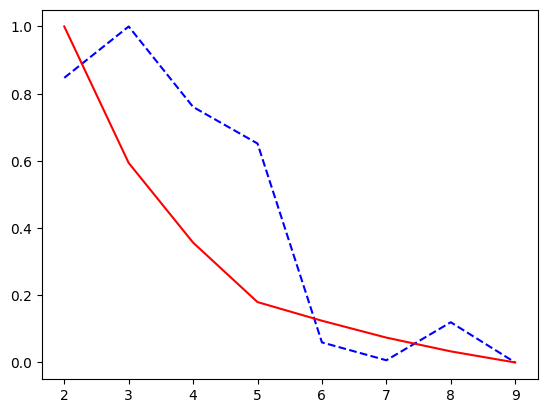

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.plot(res['param_classifier__n_clusters'], MinMaxScaler().fit_transform(res[['mean_test_ss']]), 'b--')
plt.plot(res['param_classifier__n_clusters'], MinMaxScaler().fit_transform(res[['mean_test_el']]), 'r');

In [13]:
# conclusion: 3 classes

## visualization

In [14]:
full_pipeline_f = make_pipeline(preprocessing, KMeans(n_clusters=3, random_state=1, n_init=10))
model_f = full_pipeline_f.fit(df)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=3)
df_emb = tsne.fit_transform(df_out)
data = pd.DataFrame(df_emb)
labels = model_f[1].labels_

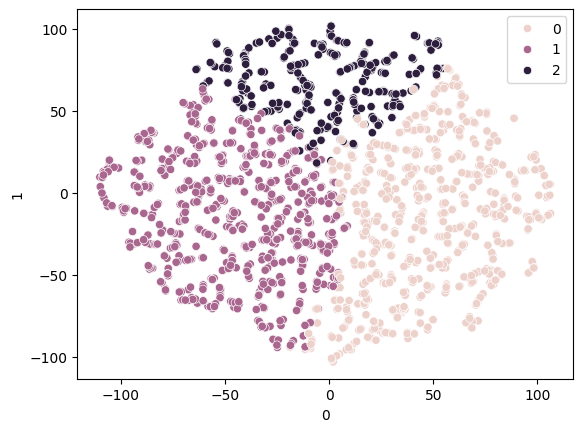

In [16]:
sns.scatterplot(data=data, x=0, y=1, hue=labels);

In [17]:
centr_sc = pd.DataFrame(model_f[1].cluster_centers_, columns=preprocessing.get_feature_names_out())
centr_sc

,date__Dt_Customer,outliers__Year_Birth,outliers__Recency,outliers__MntFruits,outliers__MntMeatProducts,outliers__MntFishProducts,outliers__MntSweetProducts,outliers__NumWebPurchases,outliers__NumStorePurchases,ohe__Response_0.0,ohe__Response_1.0
0,155.576419,1969.181223,49.427948,16.039738,97.802402,22.742795,16.025983,4.423144,5.727074,0.799127,0.200873
1,517.728850,1969.175922,48.289588,9.794577,52.777874,13.932104,9.259653,3.142950,4.700651,0.939262,0.060738
2,382.791045,1967.663184,50.263682,36.825373,372.356219,58.193035,36.935323,5.236318,8.432836,0.766169,0.233831


In [19]:
sc_mm = MinMaxScaler().fit_transform(model_f[1].cluster_centers_)
centr_mm = pd.DataFrame(sc_mm, columns=preprocessing.get_feature_names_out())

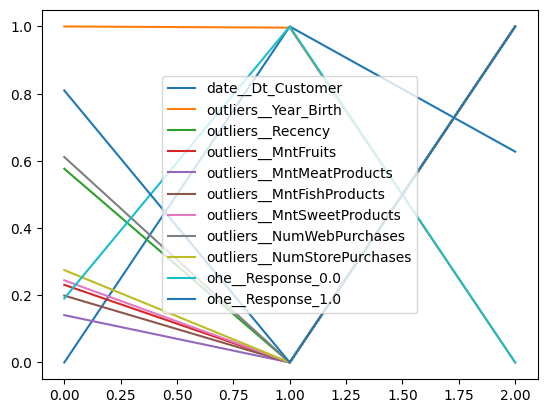

In [20]:
for i, c in enumerate(centr_sc.columns):
    plt.plot(centr_mm[c], label=c)
plt.legend();

## deviations from the average

In [21]:
df_f = df_out.copy()
df_f['cluster'] = model_f[1].labels_

In [22]:
df1 = df_f.groupby('cluster').agg(['mean','std']).T

In [23]:
tmp = df_out.copy()
tmp['99'] = 0
df2 = tmp.groupby('99').agg(['mean','std']).T

In [24]:
f = pd.DataFrame(np.c_[np.array(df1) * 100 / np.array(df2) - 100, df2.reset_index()['level_0']]).set_index(3).astype('float16')

<Axes: ylabel='3'>

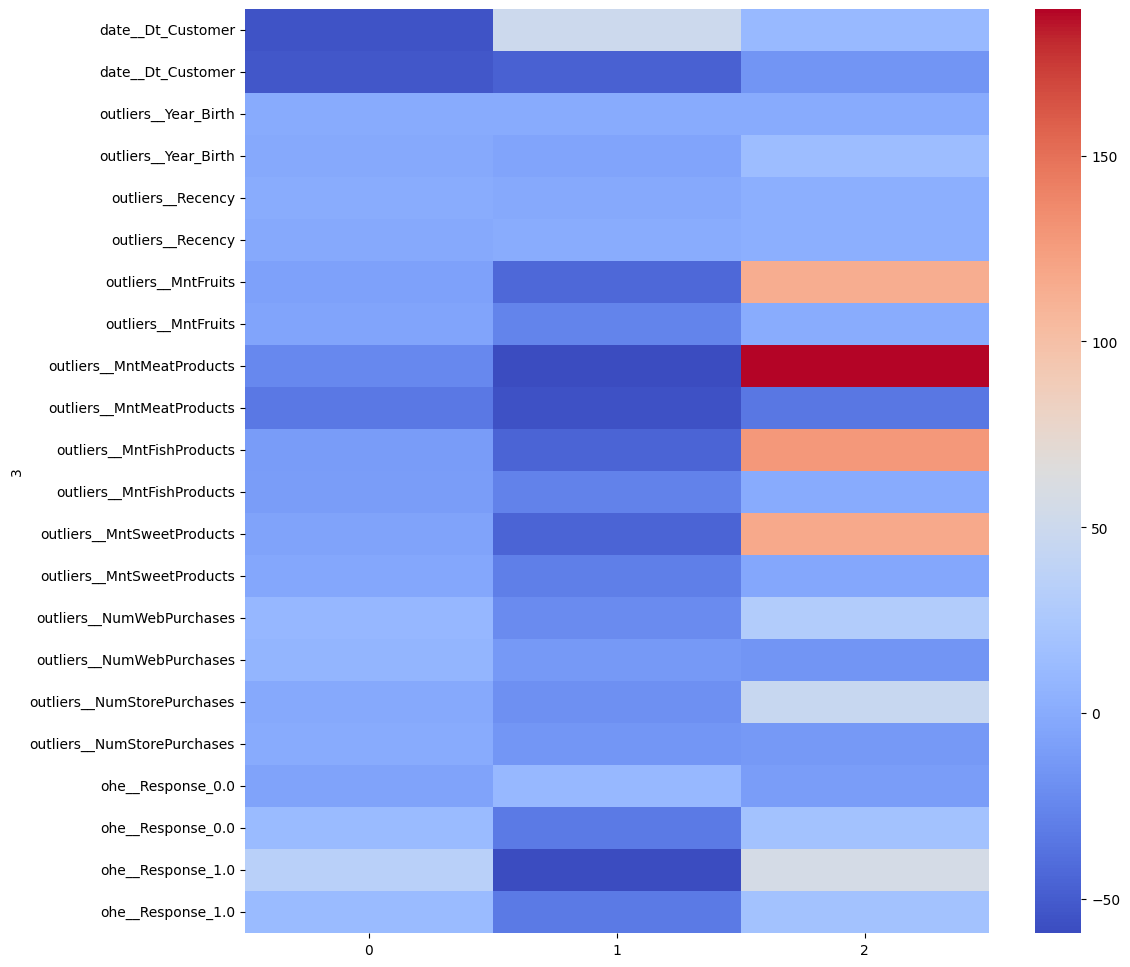

In [25]:
plt.figure(figsize = (12,12))
sns.heatmap(f, cmap='coolwarm')